# Fink & ephemerides

This notebook shows how to use the miriade IMCCE service with Fink Solar System Object data. Initial notebook from Benoit Carry.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import seaborn as sns
sns.set_context('talk')

import time

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Define a simple ephemerides query
def miriade(ident, jd):
    '''Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO

    :ident: int, float, str - asteroid identifier
    :jd: array - dates to query
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    '''
    
    # ------
    # Query Miriade 
    url = 'https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php'
    
    params = {
        '-name': f'a:{ident}',
        '-mime': 'json',
        '-tcoor': '5',
        '-output': '--jd,--colors(SDSS:r,SDSS:g)',
        '-tscale': 'UTC'
    }
    
    # Pass sorted list of epochs to speed up query
    files = {'epochs': ('epochs', '\n'.join(['%.6f' % epoch
                                             for epoch in jd]))}
    # Execute query
    try:
        r = requests.post(url, params=params, files=files, timeout=2000)
    except requests.exceptions.ReadTimeout:
        return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j['data'])
    except KeyError:
        return False

    return ephem

In [3]:
def lin_fit(x, a, b):
    """ Linear function ax + b
    """
    return a*x + b

Let's define some constants:

In [4]:
# SSO id
ssname = '8467'

# Disctionary for filters
filters = {1:'g', 2:'R', 3:'i'}

## Fink data

In [5]:
# Get data from FINK 
r = requests.post(
  'http://134.158.75.151:24000/api/v1/sso',
  json={
    'n_or_d': ssname,
    'output-format': 'json'
  }
)

# Sort by epoch - critical for ephemerides speed up
sso = pd.read_json(r.content)
sso = sso.sort_values(by='i:jd').reset_index(drop=True)

In [6]:
# Select only a few columns
cols = [
    'd:cdsxmatch', 'd:knscore', 'd:mulens_class_1', 'd:mulens_class_2',
    'd:rfscore', 'd:roid', 'd:snn_sn_vs_all', 'd:snn_snia_vs_nonia',
    'd:tracklet', 'i:jd', 'i:ra', 'i:dec', 'i:fid', 'i:magpsf', 'i:sigmapsf',
    'i:magnr', 'i:sigmagnr', 'i:isdiffpos', 'i:magzpsci'
]

fink = sso[cols]

## Ephemerides

In [7]:
# Query ephemerides
start_t = time.time()
eph = miriade(ssname, fink['i:jd'] )
end_t = time.time()

print(f"This took {end_t - start_t:.3} seconds.")

sc = SkyCoord(eph['RA'], eph['DEC'], unit=(u.deg, u.deg) )

eph = eph.drop(columns=['RA','DEC'])
eph['RA'] = sc.ra.value*15
eph['Dec'] = sc.dec.value

# Merge fink & Eph
info = pd.concat( [eph, fink], axis=1 )

This took 1.06 seconds.


In [8]:
eph

,Date,Dobs,Dhelio,VMag,SDSS:g,SDSS:r,Phase,Elong.,dRAcosDEC,dDEC,RV,RA,Dec
0,2.458792e+06,2.252634,3.078710,18.188900,18.631700,17.919600,11.965620,139.944118,-0.264338,0.148559,-14.929615,77.293830,36.161319
1,2.458799e+06,2.197904,3.075933,18.060842,18.503642,17.791542,10.096613,147.001318,-0.351163,0.120102,-12.232319,76.225942,36.537290
2,2.458805e+06,2.159458,3.073559,17.950015,18.392815,17.680715,8.389899,153.027833,-0.415792,0.089227,-9.640507,75.060738,36.792822
3,2.458805e+06,2.159430,3.073557,17.949924,18.392724,17.680624,8.388477,153.032726,-0.415840,0.089200,-9.638261,75.059688,36.793003
4,2.458805e+06,2.159428,3.073557,17.949916,18.392716,17.680616,8.388347,153.033174,-0.415845,0.089197,-9.638055,75.059592,36.793019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2.459349e+06,2.733407,3.105078,18.857366,19.300166,18.588066,18.565565,101.996871,0.233072,-0.215130,24.123591,157.799156,11.081359
111,2.459364e+06,2.945524,3.112182,19.038903,19.481703,18.769603,19.006109,89.830061,0.379720,-0.259526,24.667271,159.684915,9.653034
112,2.459366e+06,2.973415,3.113123,19.059764,19.502564,18.790464,18.998017,88.312055,0.396516,-0.264713,24.665535,159.993122,9.447780
113,2.459366e+06,2.973683,3.113132,19.059961,19.502761,18.790661,18.997872,88.297569,0.396675,-0.264763,24.665442,159.996141,9.445792


## Magnitude comparison

[ 0.00020997 -0.02159065] [5.26140744e-05 2.07109293e-02]
[ 0.00010304 -0.00436388] [3.33924577e-05 1.26610142e-02]


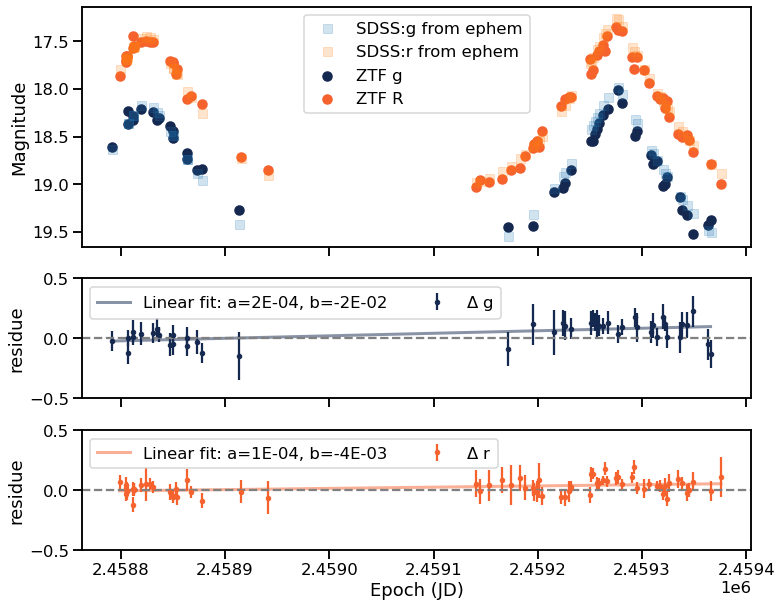

In [9]:
# Simple plot
filts = sso['i:fid'].unique()

fig, ax = plt.subplots(
    3, 1, 
    figsize=(12, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [3, 1.5, 1.5]}
)

colors = ['#15284F', '#F5622E']
for i,f in enumerate(filts):
    cond = sso['i:fid']==f
    
    ax[0].scatter(
        sso.loc[cond,'i:jd'], 
        sso.loc[cond,'i:magpsf'], 
        label='ZTF {:}'.format(filters[f]),
        color=colors[i],
        alpha=1.0
    )

    ax[0].plot(
        eph.Date[cond], 
        eph['SDSS:{}'.format(filters[f].lower())][cond], 
        ls='', 
        marker='s', 
        label='SDSS:{} from ephem'.format(filters[f].lower()), alpha=0.2)

ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].legend(loc='best')
ax[0].set_ylabel('Magnitude')

for i,f in enumerate(filts):
    cond = sso['i:fid']==f
    
    # Magnitude
    mag = sso.loc[cond,'i:magpsf'][cond]
    err= sso.loc[cond,'i:sigmapsf'][cond]
    
    ephemData = eph['SDSS:{}'.format(filters[f].lower())][cond]

    diff = mag - ephemData
    
    popt, pcov = curve_fit(lin_fit, eph.Date[cond] - eph.Date[cond].values[0], diff)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)
    
    ax[i+1].errorbar(
        eph.Date[cond], 
        diff, 
        yerr=err, 
        ls='', marker='.', label=r'$\Delta$ {}'.format(filters[f].lower()), color=colors[i])
    
    ax[i+1].plot(
        eph.Date[cond], 
        lin_fit(eph.Date[cond]- eph.Date[cond].values[0], *popt),
        label='Linear fit: a={:.0E}, b={:.0E}'.format(*popt),
        color=colors[i],
        ls='-',
        alpha=0.5,
        lw=3
    )
    
    ax[i+1].legend(loc='best', ncol=2)

    ax[i+1].set_ylim(-0.5, 0.5)
    ax[i+1].axhline(0, ls='--', color='grey')
    ax[i+1].set_ylabel('residue')
ax[2].set_xlabel('Epoch (JD)');

## Position comparison

Text(0, 0.5, '$\\Delta$DEC ($^o$)')

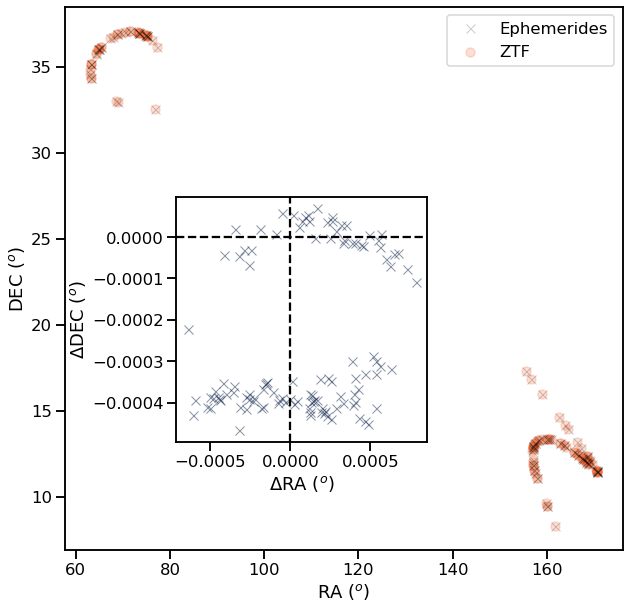

In [10]:
fig, ax = plt.subplots(
    figsize=(10, 10), 
    sharex=True,
)

ax.scatter(sso['i:ra'], sso['i:dec'], label='ZTF', alpha=0.2, color=colors[1])
    
ax.plot(eph.RA, eph.Dec, ls='', color='black', marker='x', alpha=0.2, label='Ephemerides')
ax.legend(loc='best')
ax.set_xlabel('RA ($^o$)')
ax.set_ylabel('DEC ($^o$)')

axins = ax.inset_axes([0.2, 0.2, 0.45, 0.45])

axins.plot(sso['i:ra'] - eph.RA, sso['i:dec']- eph.Dec, ls='', color=colors[0], marker='x', alpha=0.5)
axins.axhline(0, ls='--', color='black')
axins.axvline(0, ls='--', color='black')
axins.set_xlabel(r'$\Delta$RA ($^o$)')
axins.set_ylabel(r'$\Delta$DEC ($^o$)')

## Phase curve

First let's convert g and r into V. I do not have conversion formulae in hands, so let's use a crappy conversion:

$$
\begin{align}
c_{x} = \dfrac{V_{predicted}}{SDSS:x} \\
V_{obs} = x \times c_x
\end{align}
$$

where $x=g, r$. I reckon this is not rigorous, but that gives some intuition.

In [11]:
def phi1(alpha):
    """ simple form only
    """
    return 1 - 6 * alpha / np.pi

def phi2(alpha):
    """ simple form only
    """
    return 1 - 9 * alpha / (5 * np.pi)

def phi3(alpha):
    """ simple form only
    """
    return 1 - np.exp(-4 * np.pi * np.tan(alpha / 2)**(2./3))

def V(alpha, H, G1, G2):
    """ Shall we incorporate the distance?
    """
    return H - 2.5 * np.log10(G1 * phi1(alpha) + G2 * phi2(alpha) + (1 - G1 - G2) * phi3(alpha))

[17.54789085  1.23649684 -0.29664104] [0.05786977 0.11807018 0.32301755]
[17.51851084  1.309505   -0.39102623] [0.08578492 0.1647769  0.46235687]


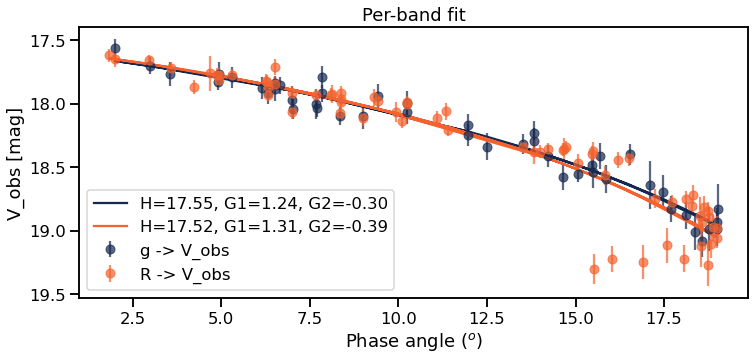

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))

for i,f in enumerate(filts):
    cond = info['i:fid']==f
    
    # stupid conversion
    conv = (info['VMag'] / info['SDSS:{}'.format(filters[f].lower())])[cond]
    
    popt, pcov = curve_fit(V, np.deg2rad(info.loc[cond,'Phase']), info.loc[cond,'i:magpsf'] * conv)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)
    
    ax.errorbar(
        info.loc[cond,'Phase'], 
        info.loc[cond,'i:magpsf'] * conv, 
        yerr=info.loc[cond,'i:sigmapsf'], 
        label='{:} -> V_obs'.format(filters[f]), 
        linestyle='None', 
        marker='o', 
        color=colors[i], 
        alpha=0.7
    )
    
    ax.plot(
        info.loc[cond,'Phase'], 
        V(np.deg2rad(info.loc[cond,'Phase']), *popt),
        label='H={:.2f}, G1={:.2f}, G2={:.2f}'.format(*popt),
        color=colors[i]
    )
    
ax.legend(loc='best')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Phase angle ($^o$)')
ax.set_ylabel('V_obs [mag]')
ax.set_title('Per-band fit');

[17.52546896  1.29085065 -0.37610456] [0.05681578 0.11124675 0.30949074]


Text(0.5, 1.0, 'Multi-band fit')

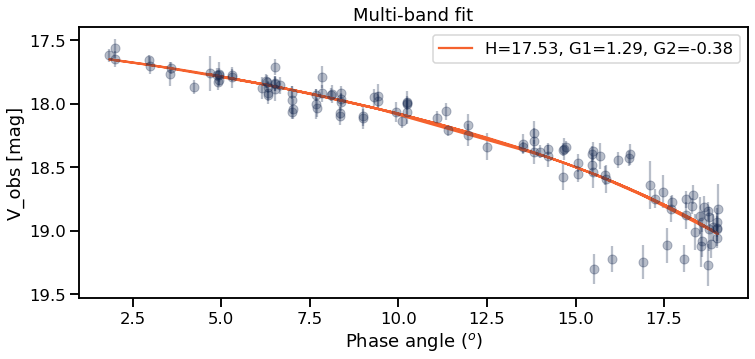

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

# stupid conversion
conv = np.ones_like(info['i:magpsf'])
for i,f in enumerate(filts):
    cond = info['i:fid']==f
    conv[cond] = (info['VMag'] / info['SDSS:{}'.format(filters[f].lower())])[cond]

popt, pcov = curve_fit(V, np.deg2rad(info['Phase']), info['i:magpsf'] * conv)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

ax.errorbar(
    info['Phase'], 
    info['i:magpsf'] * conv, 
    yerr=info['i:sigmapsf'], 
    linestyle='None', 
    marker='o', 
    color=colors[0], 
    alpha=0.3
)

ax.plot(
    info['Phase'], 
    V(np.deg2rad(info['Phase']), *popt), 
    color=colors[1],
    label='H={:.2f}, G1={:.2f}, G2={:.2f}'.format(*popt)
)

ax.legend(loc='best')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Phase angle ($^o$)')
ax.set_ylabel('V_obs [mag]')
ax.set_title('Multi-band fit')